# What drives giant number fluctuations?

We have shown in previous analysis that the convection flow field correlates with the local density fluctuation field best, among all the flow derivatives. However, highest correlation does not necessarily imply convection is the driving force, because the high correlation could just result from a simple mechanism: concentration gradient drives velocity. The magnitude may also not be the dominant one among all the flow derivatives. Indeed, our calculation shows that the divergence field is order of magnitude larger than the convection field. 

In this notebook, I want to further support, or disprove, the idea that convection is the driving force. To do that, I compare the direction of velocity and concentration gradient. The if the directions are mostly opposite, convection is likely to be cause of GNF. Otherwise, convection is surely not. 

## 1 Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
from skimage import io
import corrLib

# 2 Velocity and concentration gradient

### 2.1 Preliminary test

In [42]:
# take 08032020/01 frame 3000 as an example
n = 2900
piv_folder = r'E:\moreData\08032020\piv_imseq\05'
img_folder = r'E:\moreData\08032020\05\8-bit'
step = 25
pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
x = pivData.x.drop_duplicates()
y = pivData.y.drop_duplicates()
shape = (len(y), len(x))
u = np.array(pivData.u).reshape(shape)
v = np.array(pivData.v).reshape(shape)
img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
dcx = np.gradient(I, -step, axis=1)
dcy = np.gradient(I, -step, axis=0)
du = np.gradient(u, step, axis=1)
dv = np.gradient(v, step, axis=0)

In [18]:
prod = dcx * du + dcy * dv
prod = prod / abs(prod)

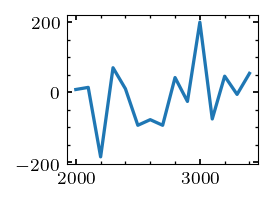

In [22]:
prod_list = []
t = range(2000, 3500, 100)
for n in t:
    pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
    u = np.array(pivData.u).reshape(shape)
    v = np.array(pivData.v).reshape(shape)
    img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    dcx = np.gradient(I, -step, axis=1)
    dcy = np.gradient(I, -step, axis=0)
    du = np.gradient(u, step, axis=1)
    dv = np.gradient(v, step, axis=0)
    prod = dcx * du + dcy * dv
    prod = prod / abs(prod)
    prod_list.append(np.sum(prod))
plt.plot(t, prod_list)

Whether the direction of velocity is the same as or opposite of the concentration gradient direction looks completely random. Next, let's put the magnitude of both quantities as weight.

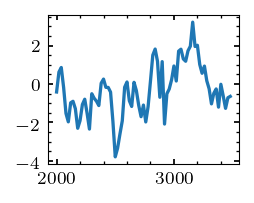

In [43]:
prod_list = []
t = range(2000, 3500, 20)
for n in t:
    pivData = pd.read_csv(os.path.join(piv_folder, '{0:04d}-{1:04d}.csv'.format(n, n+1)))
    u = np.array(pivData.u).reshape(shape)
    v = np.array(pivData.v).reshape(shape)
    img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    dcx = np.gradient(-I, step, axis=1)
    dcy = np.gradient(-I, step, axis=0)
    du = np.gradient(u, step, axis=1)
    dv = np.gradient(v, step, axis=0)
    prod = dcx * du + dcy * dv
    prod_list.append(np.sum(prod))
plt.plot(t, prod_list)

In [44]:
np.array(prod_list).sum()

-25.706796291601187

**Comment:** preliminary test shows that the correlation between velocity and spatial concentration gradient does not show a persistant trend, but rather fluctuating around 0, indicating that velocity does not always go in concentration ascent direction. This makes sense because if this is always true, the whole suspension will end up as high concentration clusters. However, there has to be a tendency towards positive correlation (velocity in positive gradient direction means going uphill) as the active turbulence develops, or as concentration goes up. Next, we will compute this correlation in a more systematic way. All frames will be taken into account.

### 2.2 Function that computes the correlation

In this section, we construct a function that computes the correlation between local concentration gradient and local velocity. Before writing the function, we first write some helper functions that makes the final step easier.

Due to the working principle of PIV, we have velocity data every other 

#### 2.2.1 Condense concentration information

Concentration has always been derived from the bright field images. While images are typically 1280\*1080, the data we use are always coarse-grained down to 50\*42. Although the down sizing step takes only several milliseconds, repeating the process over and over for hundreds of thousands of times (all images) takes a lot of time. Thus, I decide to convert the image sequences to the coarse-grained version and save them as numpy binary data. In this way, the 3000 frame video will be down sized to 3000\*50\*42 float16 numbers, which in total is 6M instead of the 4.64G. By saving this down sized data, the data also gets more portable because of the small size, while all the useful information is retained. 

In [3]:
def down_size_imseq(folder, windowsize=[50, 50], step=25):
    """
    Downsizing an image sequence of k images in given folder and save them as an numpy array of size k*m*n, 
    where m and n are the downsized dimension of each image. 
    
    Args:
    folder -- folder of image sequence
    windowsize -- parameter of corrLib.divide_windows(), pixel
    step -- parameter of corrLib.divide_windows(), pixel
    
    Returns:
    stack -- numpy array of size k*m*n
    """
    
    l = corrLib.readseq(folder)
    I_list = []
    for num, i in l.iterrows():
        img = io.imread(i.Dir)
        X, Y, I = corrLib.divide_windows(img, windowsize=windowsize, step=step)
        I_list.append(I)
    stack = np.stack(I_list, axis=0)
    
    return stack

In [4]:
%%time
folder = r'E:\moreData\08032020\00\8-bit'
stack = down_size_imseq(folder)

Wall time: 1min 36s


In [7]:
np.save(r'E:\moreData\08032020\small_image\00.npy', stack)

In [8]:
%%time
stack1 = np.load(r'E:\moreData\08032020\small_image\00.npy')

Wall time: 33 ms


**Comment:** it takes 96 seconds for the downsizing function to run over 3600 1280\*1080 images, while it only takes 0.033 seconds to load it from file. This means, for each video, this downsizing step, which can be preprocessed, will save me more than 1 minute. A script *small_imseq.py* has been implemented for this function, under *generic_proc*.

#### 2.2.2 Compute concentration gradient and correlation

Here, we compute the concentration gradient from bright field images. Since concentration is negetively proportional to image intensity, we use negative step size in function *np.gradient()* to make the value comply to convention. Once again, a bias towards positive correlation is desired.

In 2d space, concentration gradient and velocity both have two components (x and y). In our data, the dcx and dcy data will be stored in a 2\*m\*n array, where the first dimension denotes the component x or y. The PIV data are originally stored in DataFrame's, and I will rearrange the data to conform with the structure of concentration gradients. 

In [41]:
def conc_grad(img):
    """
    Compute concentration gradient based on a given bright field image *img*.
    
    Args:
    img -- bright field image (or coarse-grained one), m*n
    
    Returns:
    grad -- concentration gradient, 2*m*n.
            grad[0] is the gradient in axis 0, i.e. the Y axis.
            grad[1] is the gradient in axis 1, i.e. the X axis.
            This needs to be double checked.
    """
    
    dcx = np.gradient(img, -1, axis=1)
    dcy = np.gradient(img, -1, axis=0)
    grad = np.stack([dcy, dcx], axis=0)
    
    return grad

In [48]:
img = io.imread(r'E:\moreData\08032020\01\8-bit\3000.tif')
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
grad = conc_grad(I)

In [45]:
def rearrange_pivdata(pivData, step=None, shape=None):
    """
    Rearrange pivData into np.array of shape (2, m, n).
    
    Args:
    pivData -- DataFrame, (x, y, u, v)
    
    Returns:
    rearranged_pivData -- 2*m*n
    """
    x = pivData.sort_values(by=['x']).x.drop_duplicates()
    if step == None:
        # Need to infer the step size from pivData
        step = x.iat[1] - x.iat[0]
    
    if shape == None:
        # Need to infer shape from pivData
        y = pivData.y.drop_duplicates()
        shape = (len(y), len(x))
    
    X = np.array(pivData.x).reshape(shape)
    Y = np.array(pivData.y).reshape(shape)
    U = np.array(pivData.u).reshape(shape)
    V = np.array(pivData.v).reshape(shape)
    
    rearranged_pivData = np.stack([V, U], axis=0)
    
    return rearranged_pivData

In [46]:
pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\01\3000-3001.csv')
rearranged_pivData = rearrange_pivdata(pivData)

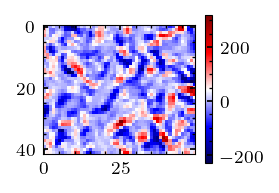

In [54]:
# inner prod
corr = np.sum(grad * rearranged_pivData, axis=0)
plt.imshow(corr, cmap='seismic')
plt.colorbar()

In [53]:
corr.mean()

0.2810515501057268

**Comment:** in the final data, correlation on each frame will be the inner product between grad and piv, summing x and y direction up. In addition, the mean of the correlation matrix will be recorded as a single number measure of correlation for that moment. The means will constitute a time series of correlation, which describes the evolution.

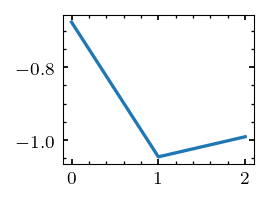

In [55]:
ts = np.load(r'E:\Github\Python\Correlation\test_images\test_corr\out_folder\corr_evolution.npy')
plt.plot(ts)